# Library import and data preprocessing

**Importing the libraries**

In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

**Data Transformation**

Defines a set of transformations to be applied to images for data augmentation and normalization during the training, validation, and testing phases.

In [4]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Importing the annotated and labeled dataset

In [ ]:
# Define the data directory
data_dir = '/home/pushan/Desktop/ML/ML_PROJECT/4628934/roi_extracted'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
#image_datasets

**Dataloader**

for loading and batching image datasets and retrieves the dataset sizes and class names.

In [10]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 6452, 'val': 806, 'test': 809}


['cocci', 'healthy', 'ncd', 'salmo']

# Classification Model

**Resnet50**

The pretrained model used for prediction by freezing all the layer except the final layer(classification layer) allowing model to update weight of the classification layer according to the given dataset.


In [11]:
# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)


for name, param in model.named_parameters():
    if "fc" in name:  
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


**Training the model**

Using transfer learning on resnet50 model to use it for classification of poultry disease given the fecal images



In [12]:
from tqdm import tqdm
import torch

# Early stopping parameters
patience = 5
best_loss = float('inf')
early_stop_counter = 0

# Lists to store metrics
val_losses = []
val_accuracies = []
train_losses = []
train_accuracies = []

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 20)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Wrap the dataloader with tqdm
        dataloader_tqdm = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Phase')

        for inputs, labels in dataloader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Store metrics in the respective lists
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        elif phase == 'val':
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())

            # Early stopping logic
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                early_stop_counter = 0  # Reset counter if validation loss improves
            else:
                early_stop_counter += 1

    # Check if early stopping is triggered
    if early_stop_counter >= patience:
        print(f'Early stopping triggered at epoch {epoch + 1}.')
        break

print("Training complete!")

# Display stored metrics
print("Train Losses:", train_losses)
print("Train Accuracies:", train_accuracies)
print("Validation Losses:", val_losses)
print("Validation Accuracies:", val_accuracies)

Epoch 1/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:15<00:00,  8.26it/s]


Train Loss: 0.8965 Acc: 0.6891


Val Phase: 100%|██████████| 202/202 [00:27<00:00,  7.24it/s]


Val Loss: 0.3037 Acc: 0.8958
Epoch 2/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:14<00:00,  8.29it/s]


Train Loss: 0.7053 Acc: 0.7498


Val Phase: 100%|██████████| 202/202 [00:26<00:00,  7.52it/s]


Val Loss: 0.4526 Acc: 0.8511
Epoch 3/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:16<00:00,  8.20it/s]


Train Loss: 0.7019 Acc: 0.7525


Val Phase: 100%|██████████| 202/202 [00:25<00:00,  7.84it/s]


Val Loss: 0.3548 Acc: 0.8797
Epoch 4/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:06<00:00,  8.67it/s]


Train Loss: 0.6310 Acc: 0.7737


Val Phase: 100%|██████████| 202/202 [00:25<00:00,  8.08it/s]


Val Loss: 0.3063 Acc: 0.9032
Epoch 5/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:09<00:00,  8.52it/s]


Train Loss: 0.6468 Acc: 0.7773


Val Phase: 100%|██████████| 202/202 [00:24<00:00,  8.09it/s]


Val Loss: 0.4281 Acc: 0.8561
Epoch 6/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:04<00:00,  8.76it/s]


Train Loss: 0.5963 Acc: 0.7867


Val Phase: 100%|██████████| 202/202 [00:27<00:00,  7.48it/s]


Val Loss: 0.2361 Acc: 0.9206
Epoch 7/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:07<00:00,  8.60it/s]


Train Loss: 0.6016 Acc: 0.7922


Val Phase: 100%|██████████| 202/202 [00:24<00:00,  8.13it/s]


Val Loss: 0.3397 Acc: 0.8958
Epoch 8/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:06<00:00,  8.67it/s]


Train Loss: 0.5921 Acc: 0.7872


Val Phase: 100%|██████████| 202/202 [00:26<00:00,  7.76it/s]


Val Loss: 0.2732 Acc: 0.9057
Epoch 9/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:06<00:00,  8.66it/s]


Train Loss: 0.6341 Acc: 0.7746


Val Phase: 100%|██████████| 202/202 [00:25<00:00,  7.96it/s]


Val Loss: 0.2360 Acc: 0.9144
Epoch 10/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:15<00:00,  8.25it/s]


Train Loss: 0.6037 Acc: 0.7847


Val Phase: 100%|██████████| 202/202 [00:26<00:00,  7.56it/s]


Val Loss: 0.3178 Acc: 0.8933
Epoch 11/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:04<00:00,  8.76it/s]


Train Loss: 0.5910 Acc: 0.7892


Val Phase: 100%|██████████| 202/202 [00:25<00:00,  7.79it/s]


Val Loss: 0.2153 Acc: 0.9293
Epoch 12/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:11<00:00,  8.43it/s]


Train Loss: 0.6213 Acc: 0.7824


Val Phase: 100%|██████████| 202/202 [00:25<00:00,  7.98it/s]


Val Loss: 0.4129 Acc: 0.8660
Epoch 13/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:10<00:00,  8.45it/s]


Train Loss: 0.5928 Acc: 0.7875


Val Phase: 100%|██████████| 202/202 [00:25<00:00,  7.93it/s]


Val Loss: 0.2512 Acc: 0.9181
Epoch 14/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:09<00:00,  8.52it/s]


Train Loss: 0.6101 Acc: 0.7849


Val Phase: 100%|██████████| 202/202 [00:26<00:00,  7.57it/s]


Val Loss: 0.2272 Acc: 0.9268
Epoch 15/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:01<00:00,  8.89it/s]


Train Loss: 0.5963 Acc: 0.7884


Val Phase: 100%|██████████| 202/202 [00:26<00:00,  7.60it/s]

Val Loss: 0.3133 Acc: 0.9069
Training complete!
Train Losses: [0.8965004186237766, 0.7053008229148119, 0.7019098297642603, 0.6309612497175776, 0.6468419202191147, 0.5962719012026416, 0.6016154289898051, 0.5921255469868412, 0.6341239996722127, 0.6037320994411296, 0.5910160493080967, 0.6213364646086147, 0.5927751991988471, 0.6101164399279294, 0.5962927959735522]
Train Accuracies: [0.6890886546807191, 0.749845009299442, 0.7524798512089275, 0.7737135771853688, 0.7772783632982021, 0.786732796032238, 0.7921574705517669, 0.787197768133912, 0.7746435213887166, 0.7847179169249845, 0.7892126472411655, 0.7823930564166149, 0.7875077495350279, 0.7848729076255424, 0.7884376937383757]
Validation Losses: [0.3037335141053511, 0.45264227665159457, 0.3547755805223778, 0.30625899838443693, 0.42812271993526396, 0.23606846465962586, 0.3396537070181082, 0.27317836358800945, 0.23596886704645811, 0.3177515836766223, 0.21532712036829843, 0.41293049477218136, 0.25119417682581835, 0.22723691304603988, 0.313302832

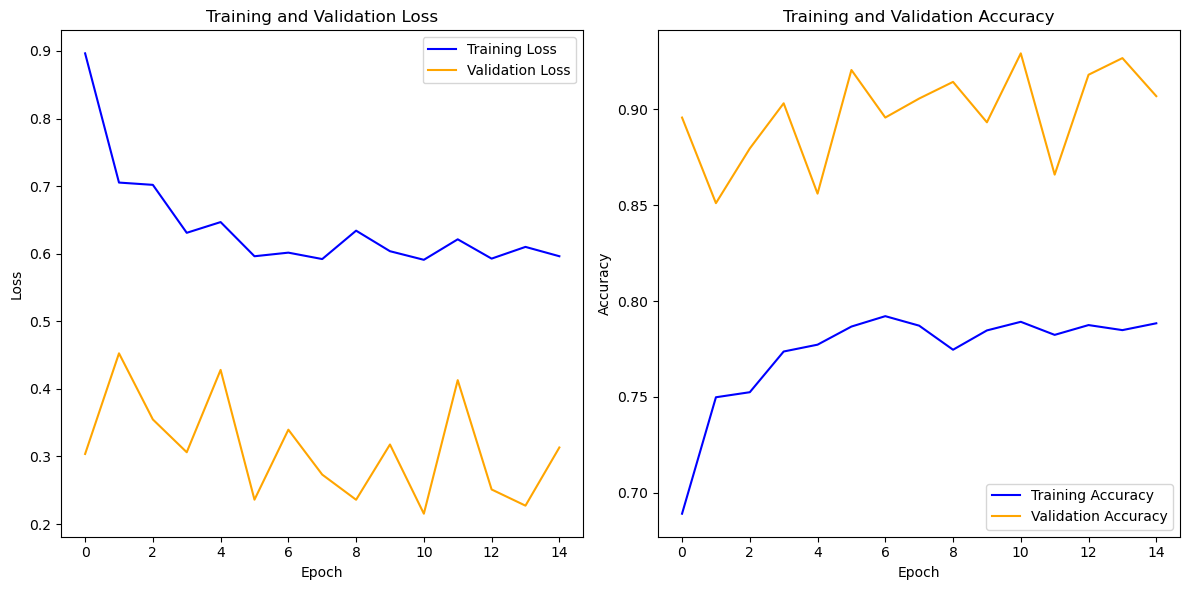

In [13]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(12, 6))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

**Model Evaluation**

Evaluating the model's performance on the test dataset to achieve the test accuracy > 92%

In [14]:
!pip install scikit-learn

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Initialize test accuracy and loss
test_loss = 0.0
correct_predictions = 0

# Initialize lists to store predictions and true labels for the confusion matrix
all_preds = []
all_labels = []

# Turn off gradients for validation (saves memory and computations)
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Calculate accuracy
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        test_loss += loss.item() * inputs.size(0)

        # Collect all predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate average loss and accuracy
test_loss = test_loss / dataset_sizes['test']
test_acc = correct_predictions.double() / dataset_sizes['test']

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 0.3305, Test Accuracy: 0.9110


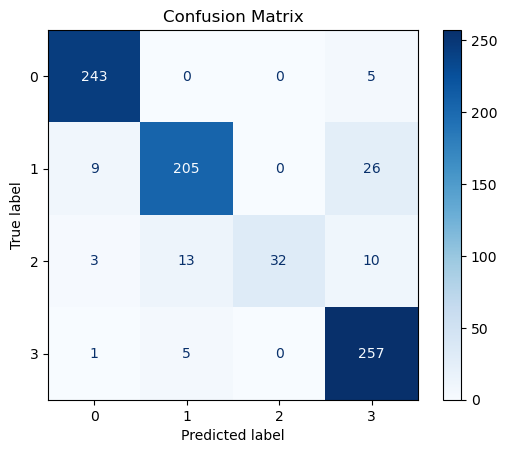

In [18]:
# Compute and display the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [19]:
torch.save(model.state_dict(), '/home/pushan/Desktop/ML/ML_PROJECT/4628934/final_files/resnet.pth')

#An utility function
This is an utility function to have prediction using the trained model and a given image using *image_path* *italicised text*

In [ ]:
from PIL import Image

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved ResNet-50 model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('/home/pushan/Desktop/ML/ML_PROJECT/4628934/final_files/resnet.pth', map_location=device))
model = model.to(device)  # Move the model to GPU or CPU
model.eval()

# Create a new ResNet-50 model with the correct final layer
new_model = models.resnet50(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  
new_model = new_model.to(device)  

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2].to(device)  # Copy only the first 2 output units and move to GPU
new_model.fc.bias.data = model.fc.bias.data[0:2].to(device)

/tmp/ipykernel_122662/2725671685.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/pushan/Desktop/ML/ML_PROJECT/4628934/final_files

**Preprocessing**

the image is being preprocessed similary as of train data before being fed up for the prediction

In [32]:
image_path = '/home/pushan/Desktop/ML/ML_PROJECT/4628934/roi_extracted/val/salmo/salmo.2101.jpg'  # Replace with the path to your image
image = Image.open(image_path)

# Use the 'test' transform from data_transforms
preprocess = data_transforms['test']
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

# Ensure the tensor is moved to the appropriate device if necessary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_batch = input_batch.to(device)

# Print the input_batch shape to verify
print("Input batch shape:", input_batch.shape)


Input batch shape: torch.Size([1, 3, 224, 224])


In [33]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['cocci', 'healthy', 'ncd', 'salmo']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: salmo


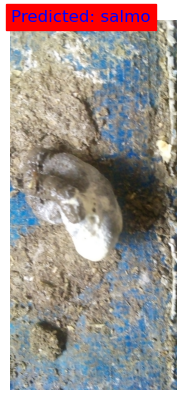

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='blue', backgroundcolor='red')
plt.show()